https://github.com/partytax/ncei-api-guide

In [1]:
#Need EOFS, dask 
#conda install -c conda-forge eofs

import pandas as pd
import xarray as xr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, progress
from eofs.xarray import Eof
from eofs.examples import example_data_path


/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Sets up a local cluster on keeling and a tmp directory for dask processes
dask.config.set(temporary_directory='/data/keeling/a/leanneb2/tmp/leanneb2-dask/')  
client = Client()  
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 503.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34682,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 503.48 GiB
Comm: tcp://127.0.0.1:33003,Total threads: 5
Dashboard: http://127.0.0.1:43355/status,Memory: 62.94 GiB
Nanny: tcp://127.0.0.1:39231,


In [3]:
# Make garbage collection explicit to prevent deadlocks
import gc
from distributed import WorkerPlugin

class WorkerExplicitGC(WorkerPlugin):
    def setup(self, worker):
        self.worker = worker
        gc.disable()             

    def transition(self, key, start, finish, *args, **kwargs):
       if finish == 'executing':
          self.worker._throttled_gc.collect()
          if gc.isenabled():
             gc.disable()

plugin = WorkerExplicitGC()
client.register_worker_plugin(plugin)

{'tcp://127.0.0.1:33003': {'status': 'OK'},
 'tcp://127.0.0.1:34185': {'status': 'OK'},
 'tcp://127.0.0.1:35533': {'status': 'OK'},
 'tcp://127.0.0.1:39250': {'status': 'OK'},
 'tcp://127.0.0.1:40191': {'status': 'OK'},
 'tcp://127.0.0.1:42837': {'status': 'OK'},
 'tcp://127.0.0.1:43211': {'status': 'OK'},
 'tcp://127.0.0.1:45601': {'status': 'OK'}}

1. Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. 

In [4]:
# This builds a file list of ERA5 monthly mean SST files and accumulated precipitation
# from 1979-2021 (files are for every year but contain monthly means)
base_url_sst = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url_precip = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2_sst = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url2_precip = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# Pandas fuction that creates an array of date time objects with an annual frequency
# during the period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_sst=[]
file_list_precip = []
for dt in pr:
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # Builds complete file name and appends it to a list of files that need to
    # be downloaded for each variable
    single_file_sst = (base_url_sst+year+base_url2_sst+month+'_'+month2+base_url3)
    file_list_sst.append(single_file_sst)

    single_file_precip = (base_url_precip+year+base_url2_precip+month+'_'+month2+base_url3)
    file_list_precip.append(single_file_precip)

In [ ]:
len(file_list_sst)

In [ ]:
len(file_list_precip)

In [5]:
# Defines Pacific Ocean latitude and longitude grid
pacific_north_lat = 65.0
pacific_south_lat = -65.0
pacific_east_lon = 120.0
pacific_west_lon = 300.0

# Creates an xarray dataset for the sst and precip variables
ds_sst = xr.open_mfdataset(file_list_sst, parallel=True, chunks={'time': '100MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
ds_precip = xr.open_mfdataset(file_list_precip, parallel=True, chunks={'time': '100MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

# # Extract the long term mean over the 1981-2010 period.
# ds['SSTK'].sel(latitude=slice(5,-5),longitude=slice(360-170,360-120)).mean(dim=['latitude','longitude'])
# mean_1981_2010 = ds_sub.sel(time=slice('1981-1-1','2010-12-31')).mean()

# mean_1981_2010.compute()

/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=

In [ ]:
ds_precip

In [ ]:
ds_sst.SSTK

In [ ]:
# # Computing the monthly mean ssts at every latitude and longitude box
# monthly_mean_sst = ds_sst.SSTK.groupby('time.month').mean()
# ds_sst.SSTK.groupby('time.month')

In [6]:
# Computes the monthly mean SST anomalies at each latitude and longitude box for 
# each year
monthly_mean_sst_ano = ds_sst.SSTK.groupby('time.month') - ds_sst.SSTK.groupby('time.month').mean(dim='time')
monthly_mean_precip_ano = ds_precip.TP.groupby('time.month') - ds_precip.TP.groupby('time.month').mean(dim='time')

In [ ]:
#https://foundations.projectpythia.org/core/xarray/computation-masking.html
monthly_mean_sst_ano

In [ ]:
monthly_mean_precip_ano

In [ ]:
monthly_mean_sst_ano.sel(longitude=290, latitude=20, method='nearest').plot()

In [ ]:
monthly_mean_precip_ano.sel(longitude=290, latitude=20, method='nearest').plot()

In [ ]:
monthly_mean_sst_ano.sel(time='1979-01', method='nearest').plot()

In [ ]:
# do I need to save this to my local computer???

2. From the dataset shown in 1, deseasonalize (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.
Deseasonalization as defined here is subtracting the long term monthly mean from each month in the time series at every point in the dataset.  Your input dimensions and output dimensions will not change - it will still be time, lat, lon

In [7]:
#monthly_mean_precip_ano = ds_precip.TP.groupby('time.month') - ds_precip.TP.groupby('time.month').mean(dim='time')
deseason_sst = ds_sst.SSTK.groupby('time.month') - ds_sst.SSTK.groupby('time.month').mean(dim='time')
deseason_precip = ds_precip.TP.groupby('time.month') - ds_precip.TP.groupby('time.month').mean(dim='time')
deseason_sst

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
deseason_sst.sel(time='1979-01', method='nearest').plot()

In [8]:
#https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [9]:
detrend_sst = detrend_dim(deseason_sst, dim='time', deg=1)
detrend_precip = detrend_dim(deseason_precip, dim='time', deg=1)
detrend_sst

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
dask.array<sub, shape=(516, 521, 721), dtype=float64, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
detrend_sst.sel(time='1979-01', method='nearest').plot()

In [ ]:
detrend_sst.sel(longitude=290, latitude=20, method='nearest').plot()

In [ ]:
ds_sst.SSTK

In [10]:
climo_mean_sst = ds_sst.groupby('time.month').mean('time')
climo_std_sst = ds_sst.groupby('time.month').std('time')
stand_ano_sst = xr.apply_ufunc(lambda x, m, s: (x - m) / s, ds_sst.groupby("time.month"),climo_mean_sst, climo_std_sst, dask="parallelized")

climo_mean_precip = ds_precip.groupby('time.month').mean('time')
climo_std_precip = ds_precip.groupby('time.month').std('time')
stand_ano_precip = xr.apply_ufunc(lambda x, m, s: (x - m) / s, ds_precip.groupby("time.month"),climo_mean_precip, climo_std_precip, dask="parallelized")



In [11]:
# Computed the precip and sst dask arrays so now they are xarray dataarrays
computed_stand_ano_precip = stand_ano_precip.TP.compute()
computed_stand_ano_sst = stand_ano_sst.SSTK.compute()

/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_i

In [ ]:
# Checking the standardized anomalies of SST by looking at a strong El Nino event
stand_ano_sst.SSTK.sel(time='1997-12-01', method='nearest').plot()

In [ ]:
# Checking the standardized anomalies of total precip by looking at a strong El Nino event
stand_ano_precip.TP.sel(time='1997-12-01', method='nearest').plot()

3. Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [12]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.

no_month_computed_stand_ano_precip = computed_stand_ano_precip.drop('month')
no_month_computed_stand_ano_sst = computed_stand_ano_sst.drop('month')

coslat = np.cos(np.deg2rad(no_month_computed_stand_ano_sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(no_month_computed_stand_ano_sst, weights=wgts)

In [13]:
# Retrieve the first 5 EOFs, expressed as the correlation between the
# PC time series and the input SST anomalies at each grid point, and the
# PC time series itself.
eofs = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)


In [26]:
for num in range(1,6):
    print(num)

1
2
3
4
5


/tmp/ipykernel_63683/1813768845.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.05, wspace=0.05)


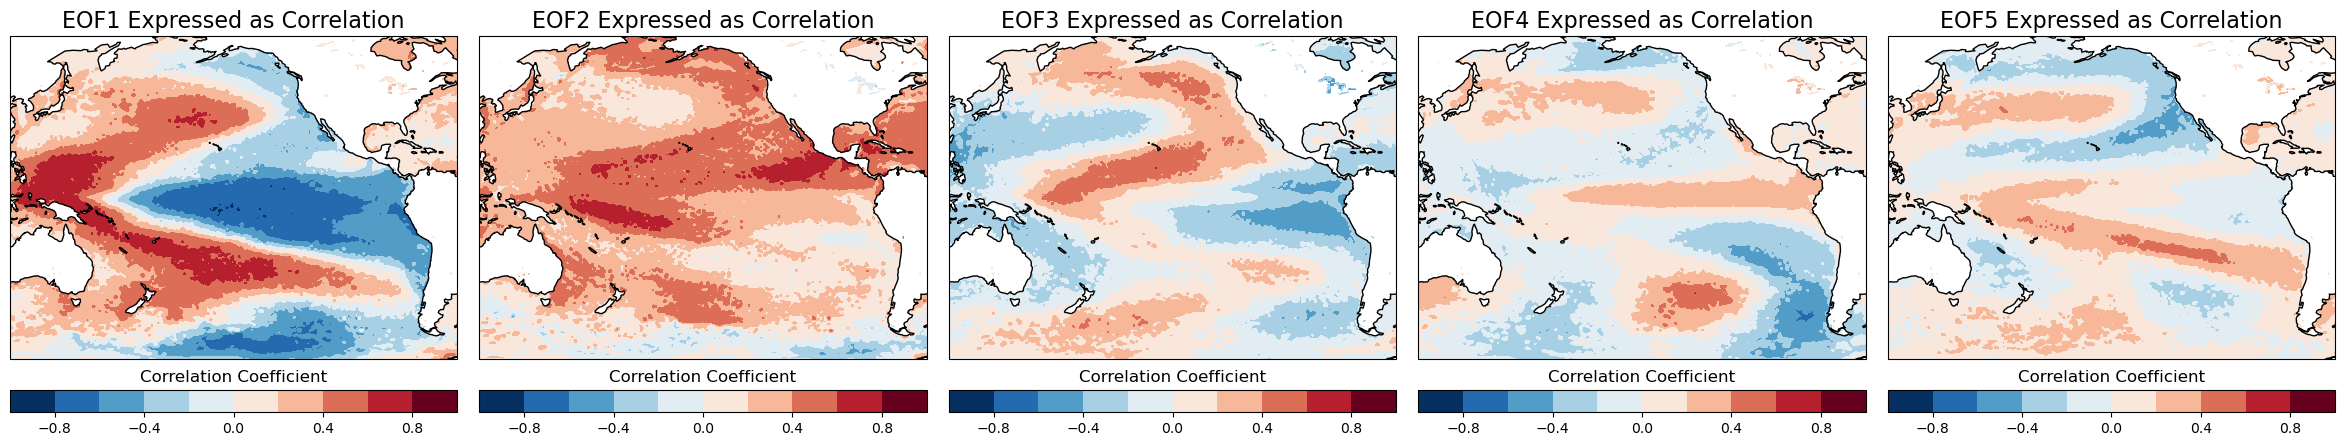

In [45]:
clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(30, 20), constrained_layout=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for num in range(1,6):
    ax = plt.subplot(1, 5, num,  projection=ccrs.PlateCarree(central_longitude=190))
    fill = eofs[num-1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.set_title(f'EOF{num} Expressed as Correlation', fontsize=16)
    clb = fig.colorbar(fill, ax=ax, orientation='horizontal', pad=0.02)
    clb.ax.set_title('Correlation Coefficient')
#plt.suptitle('Plots of the First 5 EOFs on SST Anomalies', fontsize=25, x=.5, y=.7)
plt.show()

4. Plot the percent of variance explained by the first 10 EOFs.

In [ ]:
# Calculating the percent of variance for the EOFs
varfrac = solver.varianceFraction()

In [ ]:
# Plotting the percent of variance explained by the first 10 EOFs
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(eof_num)
plt.title('Percent of the Total Variance Represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Percent of the Total Variance')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac*100), np.max(varfrac*100)+0.01)

5. Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [47]:
reconstruction = solver.reconstructedField(5)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 563, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


AttributeError: module 'collections' has no attribute 'Iterable'

In [ ]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = reconstruction.sel(time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

In [ ]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst.sel(time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies observed', fontsize=12)

6. Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot). See anything interesting?

In [ ]:
import pandas as pd

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_030_mcpr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)


import xarray as xr
ds_cpr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(longitude=slice(120.,360.-60.,4), latitude=slice(65.,-65.,4))

import pandas as pd

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_029_mlspr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)


import xarray as xr
ds_lspr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
    sel(longitude=slice(120.,360.-60.,4), latitude=slice(65.,-65.,4))

ds_pr = ds_lspr['MLSPR'] + ds_cpr['MCPR']

In [ ]:
client.close()

In [ ]:
# Getting the file that we want to mask our SST data with, selecting out the Pacific 
# domain we want
land_sea_mask = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')
pacific_domain_lsm = land_sea_mask['LSM'].sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
#pacific_domain_lsm = land_sea_mask.sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

In [ ]:
# Dropping the time dimension from the LSM datarray, adding a new time dimension
# to it so the LSM dataarray is the same size as the SST dataarray, and masking
# the SST dataarray where there is land
lsm_dropped_time = pacific_domain_lsm.squeeze('time')
sst_times = pd.date_range(start='1979-01-01',end='2021-12-31', freq='MS')
lsm_all_times = lsm_dropped_time.expand_dims(dim={"time": ds_sst.time})
lsm_all_times
# masked_sst = ds_sst.where(lsm_all_times == 1, np.nan)
masked_sst = np.ma.masked_where(lsm_all_times == 1, ds_sst.SSTK)